# Library Installation

Install Pillow for image processing and pytesseract for OCR. 

# Extracting Text from Image using pytesseract

This code snippet uses the pytesseract library to extract text from an image. First, it opens an image file named 'test2_1.png' using the Python Imaging Library (PIL). The pytesseract.image_to_string function is used to extract text from the opened image. Finally, the extracted text is printed to the console.

In [6]:
from PIL import Image
import pytesseract

# Open the image file
image = Image.open('test2_1.png')

# Use pytesseract to extract text from the image
text = pytesseract.image_to_string(image)

# Print the extracted text
print(text)

ISHN PONS SS

SPASMOMEN

otilonium bromide 40 mg

10 film-coated tablets

For oral use



# Extracting Text from Image using keras-ocr

In [ ]:
pip install keras-ocr -q

In [ ]:
pip install tensorflow==2.10.0 keras==2.10.0

### Results with picture

Looking for C:\Users\Doha\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Doha\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 6s 6s/step


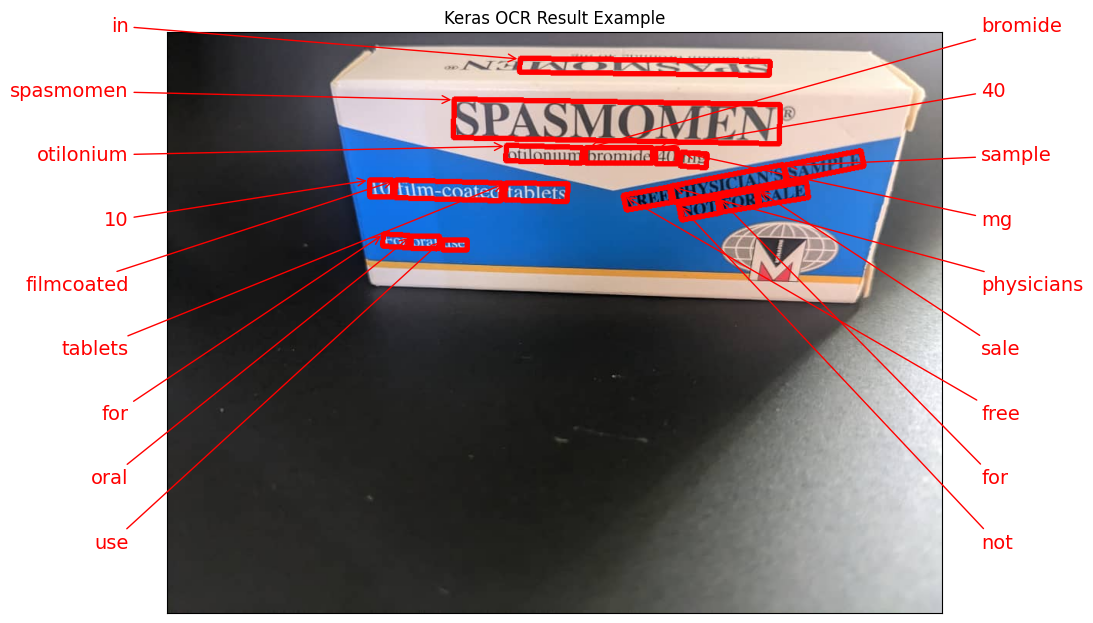

In [7]:
import keras_ocr
import matplotlib.pyplot as plt

# Set up the pipeline
pipeline = keras_ocr.pipeline.Pipeline()

# Path to your image file
image_path = 'test2.png'

# Read the image
image = keras_ocr.tools.read(image_path)

# Perform OCR
images = [image]
results = pipeline.recognize(images)

# Plot the image with annotations
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
keras_ocr.tools.drawAnnotations(image=image, predictions=results[0], ax=ax)
ax.set_title('Keras OCR Result Example')
plt.show()

# Extracting Drugs name and other information using the drug_list file

This script integrates OCR capabilities using keras_ocr to extract text from an image (test2_1.png). It preprocesses the OCR output to remove non-alphanumeric characters and converts text to lowercase. The script then matches this processed text against a medication database (drug_list.xlsx). It identifies potential matches by initially comparing the first word of each medication designation and iteratively refines matches based on subsequent words, focusing on dosage units like 'mg', '%', 'g', and 'ml'. Finally, it displays the identified matches in a structured format.

In [ ]:
import keras_ocr
import pandas as pd
import re
import numpy as np

# Read and preprocess the medication database
data = pd.read_excel('drugs_list_1.xlsx')
df = data[['GENERIC DESCRIPTION', 'DESIGNATION']]
df.loc[:, 'GENERIC DESCRIPTION'] = df['GENERIC DESCRIPTION'].astype(str) 
df.loc[:, 'GENERIC DESCRIPTION'] = df['GENERIC DESCRIPTION'].str.lower()
df.loc[:, 'GENERIC DESCRIPTION'] = df['GENERIC DESCRIPTION'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# OCR Integration
pipeline = keras_ocr.pipeline.Pipeline()
image_path = 'test2_1.png'
image = keras_ocr.tools.read(image_path)
images = [image]
results = pipeline.recognize(images)

# Preprocess OCR output
ocr_text = " ".join([word[0] for word in results[0]]).lower()
ocr_text = re.sub(r'[^\w\s]', '', ocr_text)

# Create an empty DataFrame with the same columns as the original DataFrame df
prediction_df = pd.DataFrame(columns=df.columns)

# Regular expression pattern to split words based on digits followed by 'mg' or '%'
pattern = re.compile(r'(\d+)(mg|%|g|ml)')

# Convert OCR text to a set of words for faster lookup
ocr_text_set = set(ocr_text.split())

# Vectorized matching for the first word in designation
df['first_word'] = df['DESIGNATION'].apply(lambda x: x.split()[0].lower() if pd.notna(x) and x.split() else '')

# Now you can use your existing logic
matching_rows = df['first_word'].isin(ocr_text_set)
prediction_df = df[matching_rows].copy()


def filter_rows_by_word(df, ocr_text_set, word_index, pattern):
    rows_to_keep = []
    for index, row in df.iterrows():
        designation_words = row['DESIGNATION'].split()
        if len(designation_words) > word_index:
            word = designation_words[word_index].lower()
            # Check if the word contains 'mg' or '%'
            if 'mg' in word or '%' in word or 'g' in word or 'ml' in word:
                # Split the word based on the regular expression pattern
                splits = pattern.findall(word)
                # Process each split
                keep_row = any(split[0] in ocr_text_set for split in splits)
                if keep_row:
                    rows_to_keep.append(index)
            else:
                if word in ocr_text_set:
                    rows_to_keep.append(index)
    return df.loc[rows_to_keep]

# Next detection
init = 1
while len(prediction_df) > 1:
    prediction_df = filter_rows_by_word(prediction_df, ocr_text_set, init, pattern)
    init += 1

# Display the resulting DataFrame
print(prediction_df)

## using pytesseract insteed of keras for time improvement

In [ ]:
import time
import pandas as pd
import re
from PIL import Image
import pytesseract


# Record the start time
start_time = time.time()

# Set the path to your Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"  

# Read and preprocess the medication database
df = pd.read_excel('drugs_list_1.xlsx')

# OCR Integration
image_path = 'test2_1.png'
image = Image.open(image_path)
text = pytesseract.image_to_string(image)


# Preprocess OCR output
ocr_text = text.lower()
ocr_text = re.sub(r'[^\w\s]', '', ocr_text)

# Create an empty DataFrame with the same columns as the original DataFrame df
prediction_df = pd.DataFrame(columns=df.columns)

# Regular expression pattern to split words based on digits followed by 'mg' or '%'
pattern = re.compile(r'(\d+)(mg|%|g|ml)')

# Convert OCR text to a set of words for faster lookup
ocr_text_set = set(ocr_text.split())

# Vectorized matching for the first word in designation
df['first_word'] = df['DESIGNATION'].apply(lambda x: x.split()[0].lower() if pd.notna(x) and x.split() else '')

# Words to exclude (like numbers and specific words)
exclude_words = {'ml', 'mg', '%','g'}

# Function to check if a string is numeric
def is_numeric(s):
    return s.isdigit() or (s.startswith('-') and s[1:].isdigit())

# Filter out numeric values and excluded words
ocr_txt_cond = {word for word in ocr_text_set
                if not is_numeric(word)
                and word.lower() not in exclude_words
                and not re.match(r'^[\d.,]+$', word)}  # Exclude numeric-like strings


# Now you can use your existing logic
matching_rows = df['first_word'].isin(ocr_txt_cond)
prediction_df = df[matching_rows].copy()


def filter_rows_by_word(df, ocr_text_set, word_index, pattern):
    rows_to_keep = []
    for index, row in df.iterrows():
        designation_words = row['DESIGNATION'].split()
        if len(designation_words) > word_index:
            word = designation_words[word_index].lower()
            # Check if the word contains 'mg' or '%'
            if 'mg' in word or '%' in word or 'g' in word or 'ml' in word:
                # Split the word based on the regular expression pattern
                splits = pattern.findall(word)
                # Process each split
                keep_row = any(split[0] in ocr_text_set for split in splits)
                if keep_row:
                    rows_to_keep.append(index)
            else:
                if word in ocr_text_set:
                    rows_to_keep.append(index)
    return df.loc[rows_to_keep]

# Next detection
init = 1
while len(prediction_df) > 1:
    prediction_df = filter_rows_by_word(prediction_df, ocr_text_set, init, pattern)
    init += 1


# Display the resulting DataFrame
print(prediction_df)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.2f} seconds")